# Recommendation System

## Business Understanding

The analysis below is for a custom recommendation system for songs.  The data chosen for training/testing came from the [Million Song Dataset Challenge](https://www.kaggle.com/c/msdchallenge#description). The dataset was originally provided by The Echo Nest and made available by [Columbia University](https://labrosa.ee.columbia.edu/millionsong/) with the puprose encouraging research in machine learning.  The preditive modeling will be done to determine songs the user would like to listen to based on the current song playing.  

## Data Understanding

The analysis will involve two datasets.   The song usage data and the song information data.

The first is the Taste Profile subset.   The data includes a unique hash value for each user along with the song identification number and the number of times the user has played that particular song.  The data was not gathered over a specified time.  Rather the data is dependent upon the user having a minimum of 10 unique songs.  

The second dataset is the song data which provides details about the song.  The usage data only contains the song identification number while the song data provides the song title, artist, release, and year.  

Downloading the usage and song data:

In [1]:
%%capture

import graphlab as gl
import graphlab.aggregate as agg
from matplotlib import pyplot as plt
usage_data = gl.SFrame.read_csv("../data/kaggle_visible_evaluation_triplets.txt",
                                header=False,
                                delimiter='\t',
                                column_type_hints={'X3':int})

songs = gl.SFrame.read_csv("../data/song_data.csv")

Change data labels to be human readable:

In [2]:
%%capture
print(usage_data.rename({'X1':'user', 'X2': 'song_id', 'X3': 'plays'}))

The usage data has three fields (`user`, `song_id`, and `plays`) which describes how many times (`play`) a `song` is listened to by a `user`.

In [3]:
usage_data.head()

user,song_id,plays
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOBONKR12A58A7A7E0,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOEGIYH12A6D4FC0E3,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOFLJQZ12A6D4FADA6,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOHTKMO12AB01843B0,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SODQZCY12A6D4F9D11,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOXLOQG12AF72A2D55,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUVUHC12A67020E3B,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUQERE12A58A75633,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOIPJAX12A8C141A2D,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOEFCDJ12AB0185FA0,2


The song data has five fields (`song_id`, `title`, `release`, `artist_name`, and `year`.

In [5]:
songs.head()

song_id,title,release,artist_name,year
SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze PresentsWinter Sessions ...,Der Mystic,0
SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor""Sinfonie ...",Berwald: Symphonies Nos.1/2/3/4 ...,David Montgomery,0
SOQVRHI12A6D4FB2D7,We Have Got Love,Strictly The Best Vol. 34,Sasha / Turbulence,0
SOEYRFT12AB018936C,2 Da Beat Ch'yall,Da Bomb,Kris Kross,1993
SOPMIYT12A6D4F851E,Goodbye,Danny Boy,Joseph Locke,0
SOJCFMH12A8C13B0C2,Mama_ mama can't you see? ...,March to cadence with theUS marines ...,The Sun Harbor's Chorus-Documentary Recordings ...,0


To enhance the `usage_data` records details from `songs` data will be included.   The inclusion of the details will allow for subjective review as well as expand the analysis from song usage to artist usage.  A merge on the `usage_data` and `songs` datasets will provide the needed details.

In [4]:
ud_df = usage_data.to_dataframe()
song_df = songs.to_dataframe()

new_df = ud_df.merge(song_df, how='left', left_on='song_id', right_on='song_id')

combo_songs = gl.SFrame(new_df)
combo_songs['song_name'] = combo_songs['title'] + ' (' + combo_songs['artist_name'] +')'
combo_songs['user', 'title', 'artist_name', 'plays', 'song_name'].head

<bound method SFrame.head of Columns:
	user	str
	title	str
	artist_name	str
	plays	int
	song_name	str

Rows: 1491952

Data:
+-------------------------------+-------------------------------+
|              user             |             title             |
+-------------------------------+-------------------------------+
| fd50c4007b68a3737fe052d5a4... |         You're The One        |
| fd50c4007b68a3737fe052d5a4... | Horn Concerto No. 4 in E f... |
| fd50c4007b68a3737fe052d5a4... |            Tive Sim           |
| fd50c4007b68a3737fe052d5a4... | Catch You Baby (Steve Pitr... |
| fd50c4007b68a3737fe052d5a4... |          El Cuatrero          |
| fd50c4007b68a3737fe052d5a4... | Unite (2009 Digital Remaster) |
| d7083f5e1d50c264277d624340... |           Lift Me Up          |
| d7083f5e1d50c264277d624340... |        Living In A Lie        |
| d7083f5e1d50c264277d624340... |         Open Your Eyes        |
| d7083f5e1d50c264277d624340... |           Kurtizana           |
+-----------------

Collaborative filtering based on song and user is the primary objective.  In addition, the user and artist data will be analyzed in the same fashion to determine the preferred method.   Both models will be trained, tested, and compared.  

In [6]:
df_artist = new_df.groupby(by=['user','artist_name'])[['plays']].sum().reset_index()
df_artist.head()

artist = gl.SFrame(df_artist)
artist.head

<bound method SFrame.head of Columns:
	user	str
	artist_name	str
	plays	int

Rows: 1133382

Data:
+-------------------------------+--------------------------------+-------+
|              user             |          artist_name           | plays |
+-------------------------------+--------------------------------+-------+
| 00007a02388c208ea7176479f6... |             Dredg              |   3   |
| 00007a02388c208ea7176479f6... |            Local H             |   1   |
| 00007a02388c208ea7176479f6... |              M83               |   2   |
| 00007a02388c208ea7176479f6... |            No Doubt            |   1   |
| 00007a02388c208ea7176479f6... |            Pantera             |   1   |
| 00007a02388c208ea7176479f6... |           Sam Sparro           |   2   |
| 00007a02388c208ea7176479f6... |      Stone Temple Pilots       |   3   |
| 00014a76ed063e1a749171a253... |      Angels and Airwaves       |   4   |
| 00014a76ed063e1a749171a253... |           Moodymann            |   2   |
| 

### Data Visualization

The dataset being utilized for the project is significant in size.   Due to the size, the visuals can be challenging to present.  To provide an image of the number of songs and the number of plays, each entry was categorized based on the number of plays.  The pie chart below shows the percentage of songs in each category.   

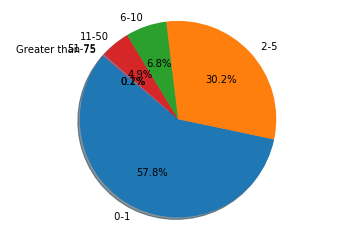

In [7]:
#Create the category function
def f(row):
    if row['plays'] <= 1:
        val = ' 0-1'
    elif row['plays'] <= 5:
        val = ' 2-5'
    elif row['plays'] <= 10:
        val =  ' 6-10'
    elif row['plays'] <= 50:
        val =  '11-50'
    elif row['plays'] <= 75:
        val =  '51-75'
    elif row['plays'] >75:
        val =  'Greater than 75'
    return val

#Apply the category function 
new_df['category'] = new_df.apply(f, axis=1)

#Confirm the new category added
new_df.head()

#Group by categories

pie_chart = new_df.groupby(by=['category'])[['plays']].count().reset_index()

pie_chart.head()

#Plot
plt.pie(pie_chart['plays'], labels=pie_chart['category'], autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

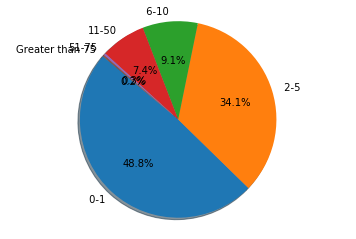

In [8]:
#Apply the category function 
df_artist['category'] = df_artist.apply(f, axis=1)
                                  
art_pc = df_artist.groupby(by=['category'])[['plays']].count().reset_index()
art_pc.head()

plt.pie(art_pc['plays'], labels=art_pc['category'], autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

With the song data, over half of the information is based on a song being played a single time.  All data will remain in the analysis; however, the model will be chosen to consider the number of times the song was played.

In [9]:
combo_songs.show()

Canvas is accessible via web browser at the URL: http://localhost:8017/index.html
Opening Canvas in default web browser.


In [10]:
artist.show()

Canvas is accessible via web browser at the URL: http://localhost:8017/index.html
Opening Canvas in default web browser.


Executing the `graphlab show` will provide summary information about the data in a local browser using GraphLab Canvas.   

The song data includes over 110,000 users listening to over 166,433 unique songs.   The data includes 138,499 unqiue song titles.   The inference is 27,934 songs have the same title although they are different songs.   Analysis will need to be done on the `song_id` rather than the `title`.   Songs were played between 1 times and 923 times.  Both the song data as well as the artist data contain 28,266 unique artists.   Neither dataset has missing values.  The year has some missing values that are populated with 0.  Detail on the missing years can be found in the GraphLab Canvas.   Due to 20% of the year data missing, analysis will not include the year informaiton.  

Since the user identification is based on a user ID, the possiblities of a single person having multiple user IDs or a single user ID being used by multiple individuals cannot be eliminated.   Since the sharing of user IDs is common with families, our analysis will proceed with caution.  

## Train and Adjust parameters

In [11]:
combo_songs

user,song_id,plays,title,release
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOBONKR12A58A7A7E0,1,You're The One,If There Was A Way
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOEGIYH12A6D4FC0E3,1,Horn Concerto No. 4 in Eflat K495: II. Romance ...,Mozart - Eine kleineNachtmusik ...
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOFLJQZ12A6D4FADA6,1,Tive Sim,Nova Bis-Cartola
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOHTKMO12AB01843B0,1,Catch You Baby (StevePitron & Max Sanna Radio ...,Catch You Baby
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SODQZCY12A6D4F9D11,1,El Cuatrero,From Argentina To TheWorld ...
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOXLOQG12AF72A2D55,1,Unite (2009 DigitalRemaster) ...,Hello Nasty (RemasteredEdition) ...
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUVUHC12A67020E3B,1,Lift Me Up,Lift Me Up EP
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUQERE12A58A75633,1,Living In A Lie,Planet Of The Apes - BestOf Guano Apes ...
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOIPJAX12A8C141A2D,1,Open Your Eyes,Nice 90s
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOEFCDJ12AB0185FA0,2,Kurtizana,Bud a nebe


#### Song Recommendation
The following is the training and testing of the song usage data.  The analysis includes both the user and the song information.    

A recommender based on the plays from users will be created.  The recommender will suggest 5 songs for each user based on the feedback from other users.

In [12]:
train_song, test_song = gl.recommender.util.random_split_by_user(combo_songs,
                                                      user_id="user", item_id="song_id",
                                                      item_test_proportion=0.2)

from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

song_rec = gl.recommender.item_similarity_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="cosine")

rmse_results = song_rec.evaluate(test_song)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Warning: Ignoring columns title, release, artist_name, year, song_name;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1489352 observations with 110000 users and 163095 items.

Data prepared in: 2.37418s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.477ms                        | 1.75       |

| 123.075ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 20.514ms                           | 0          |

| 364.346ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 564.488ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.43s                               | 0                | 32              |

| 4.43s                               | 39.75            | 65194           |

| 5.43s                               | 77.75            | 127105          |

| 7.70s                               | 100              | 163095          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.88972s


Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.00463499420626 | 0.00225955967555 |
|   2    | 0.00463499420626 | 0.00414252607184 |
|   3    | 0.00540749324063 | 0.00701180819953 |
|   4    | 0.00463499420626 | 0.0074808254704  |
|   5    | 0.00393974507532 | 0.00786707498758 |
|   6    | 0.00347624565469 | 0.00815676212548 |
|   7    | 0.00430392319152 | 0.0116054185289  |
|   8    | 0.00420046349942 | 0.0124551674668  |
|   9    | 0.00424874468907 |  0.015517574353  |
|   10   | 0.00428736964079 | 0.0161079135876  |
+--------+------------------+------------------+
[10 rows x 3 columns]



Less than 4 successfully started. Using only 3 workers.

All operations will proceed as normal, but lambda operations will not be able to use all available cores.

(The location of the log file is printed at the start of the GraphLab server).

('\nOverall RMSE: ', 6.278714718524088)

Per User RMSE (best)
+-------------------------------+-------+----------------+
|              user             | count |      rmse      |
+-------------------------------+-------+----------------+
| 61b79361ff80fe57a95015f19b... |   1   | 0.624539837241 |
+-------------------------------+-------+----------------+
[1 rows x 3 columns]


Per User RMSE (worst)
+-------------------------------+-------+--------------+
|              user             | count |     rmse     |
+-------------------------------+-------+--------------+
| 617ed2dd7af6b88f157d6fdfa9... |   2   | 49.244289009 |
+-------------------------------+-------+--------------+
[1 rows x 3 columns]


Per Item RMSE (best)
+--------------------+-------+----------------+
|      song_id       | count |      rmse      |
+--------------------+-------+----------------+
| SONWILZ12A8C1362B5 |   1   | 0.457430371216 |
+--------------------+-------+----------------+
[1 rows x 3 columns]


Per It

In [13]:
rmse_results['rmse_overall']

6.278714718524088

In [14]:
rmse_results['rmse_by_user']

user,count,rmse
afa789497ac76be6b065f0798f1b32dc88b74e07 ...,3,1.0
bef3adf0c1b916ac9b549f77984fb607701359c0 ...,3,5.0
9156df28bd49301f03306f6016faba0ab4a240cb ...,2,1.0
d9a7bbc39cb6cae61b959de6da778a9ab30c2f14 ...,3,1.0
c174d59c27220c94999bf67cd98fd3eca67f7ab0 ...,4,1.0
1be569aefb976bae9aa6a29af47db2e8d666dcd2 ...,9,4.20317340431
ee2e4d4bceccab6ed27930d2b643f4aa5d51b5a2 ...,1,1.45343492031
ad735bb68f23dd440dc86a66706bef6a9e61d7c8 ...,1,1.0
e7a396b784c0140d0d86930b49ab309c8d93e93b ...,2,10.4920118747
bec7714c456d4fc41bd194ba49c8dc6f9c1bc02e ...,4,6.61437827766


In [15]:
rmse_results['rmse_by_item']

song_id,count,rmse
SOZEJTU12A8C1422B8,1,1.0
SOEKEWC12A8C132A59,1,1.0
SOQIPYO12AAF3B5B1D,1,10.0
SOYIOZB12A58A797FC,1,4.0
SOPCFDZ12A58A7A13C,1,1.0
SOANOGG12A6D4FA13F,1,2.0
SOLACVK12A8C13ABAA,1,1.0
SOOCALE12A6701EB05,1,1.0
SOZVCRW12A67ADA0B7,3,5.35412613474
SOSZAST12A6D4F6245,1,2.0


In [16]:
train_song, test_song = gl.recommender.util.random_split_by_user(combo_songs,
                                                      user_id="user", item_id="song_id",
                                                      item_test_proportion=0.2)

from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

song_rec = gl.recommender.item_similarity_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="pearson")

rmse_results = song_rec.evaluate(test_song)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Warning: Ignoring columns title, release, artist_name, year, song_name;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1489352 observations with 110000 users and 163095 items.

Data prepared in: 3.87733s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.001ms                        | 0.75       |

| 184.101ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 38.028ms                           | 0          |

| 477.839ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 763.511ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.16s                               | 0                | 32              |

| 5.16s                               | 29.25            | 47931           |

| 6.17s                               | 70               | 114513          |

| 7.16s                               | 93.5             | 152758          |

| 8.68s                               | 100              | 163095          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.98634s


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 5.471660027577598)

Per User RMSE (best)
+-------------------------------+-------+------+
|              user             | count | rmse |
+-------------------------------+-------+------+
| 9cd9fa4ccb4543567a34194e4f... |   1   | 0.0  |
+-------------------------------+-------+------+
[1 rows x 3 columns]


Per User

In [17]:
rmse_results['rmse_overall']

5.471660027577598

In [18]:
rmse_results['rmse_by_user']

user,count,rmse
afa789497ac76be6b065f0798f1b32dc88b74e07 ...,3,2.09423599018
bef3adf0c1b916ac9b549f77984fb607701359c0 ...,3,3.33469150218
9156df28bd49301f03306f6016faba0ab4a240cb ...,2,0.867002389363
d9a7bbc39cb6cae61b959de6da778a9ab30c2f14 ...,3,3.1165604275
c174d59c27220c94999bf67cd98fd3eca67f7ab0 ...,4,1.63401832999
1be569aefb976bae9aa6a29af47db2e8d666dcd2 ...,9,2.04651934683
ee2e4d4bceccab6ed27930d2b643f4aa5d51b5a2 ...,1,0.961639714178
ad735bb68f23dd440dc86a66706bef6a9e61d7c8 ...,1,1.33333333333
e7a396b784c0140d0d86930b49ab309c8d93e93b ...,2,7.54179338596
bec7714c456d4fc41bd194ba49c8dc6f9c1bc02e ...,4,5.83571733561


In [19]:
rmse_results['rmse_by_item']

song_id,count,rmse
SOZEJTU12A8C1422B8,1,1.41192632583
SOEKEWC12A8C132A59,1,2.75925925926
SOQIPYO12AAF3B5B1D,1,6.83146067416
SOYIOZB12A58A797FC,1,1.30303030303
SOPCFDZ12A58A7A13C,1,2.14285714286
SOANOGG12A6D4FA13F,1,2.0
SOLACVK12A8C13ABAA,1,1.18181818182
SOOCALE12A6701EB05,1,1.85714285714
SOZVCRW12A67ADA0B7,3,3.72303461433
SOSZAST12A6D4F6245,1,0.516129032258


The RMSE (root mean square error) is evaluated for both the cosine and pearson model for the item similarity recommender.  The pearson model is the preferred model with the lower RMSE (5.47 compared to 6.28).

#### Artist Recommendation
Music recommendations may be offered in multiple forms.  In addition to the recommendation of songs, the analysis includes the recommendation of music by artist.  The data was trained as tested the same as the song data to offere comparison of the two collaborative filtering results.   

In [20]:
train_art, test_art = gl.recommender.util.random_split_by_user(artist,
                                                      user_id="user", item_id="artist_name",
                                                      item_test_proportion=0.2)

from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

art_rec = gl.recommender.item_similarity_recommender.create(train_art,
                                                             user_id="user",
                                                             item_id="artist_name",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="cosine")

rmse_results = art_rec.evaluate(test_art)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Preparing data set.

Data has 1131349 observations with 109996 users and 28359 items.

Data prepared in: 1.69528s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.003ms                        | 2.5        |

| 77.06ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.70s                               | 0                | 0               |

| 6.33s                               | 43.5             | 12357           |

| 6.68s                               | 64               | 18171           |

| 19.57s                              | 100              | 28359           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 19.9879s


Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.0024154589372  | 0.00144927536232 |
|   2    | 0.0024154589372  | 0.00305958132045 |
|   3    | 0.00201288244767 | 0.00346215780998 |
|   4    | 0.00332125603865 | 0.00678341384863 |
|   5    | 0.00434782608696 | 0.0113123993559  |
|   6    | 0.00402576489533 | 0.0122181964573  |
|   7    | 0.0036231884058  | 0.0126207729469  |
|   8    | 0.00347222222222 | 0.0141304347826  |
|   9    | 0.00322061191626 | 0.0143719806763  |
|   10   | 0.00326086956522 | 0.0163345410628  |
+--------+------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 13.997813002536036)

Per User RMSE (best)
+-------------------------------+-------+----------------+
|              user             | count |      rmse      |
+-------------------------------+-------+----------------+


In [21]:
rmse_results['rmse_overall']

13.997813002536036

In [22]:
rmse_results['rmse_by_user']

user,count,rmse
3e0f03a88eeeb4645b8f472aefc16a8a45fd4fa6 ...,2,2.51534644194
d9a7bbc39cb6cae61b959de6da778a9ab30c2f14 ...,1,0.967491209507
c174d59c27220c94999bf67cd98fd3eca67f7ab0 ...,4,1.0
68d1c0c0f0df90c9bd010b11fd403bf5866c9648 ...,1,5.0
1be569aefb976bae9aa6a29af47db2e8d666dcd2 ...,4,10.4642247682
ee2e4d4bceccab6ed27930d2b643f4aa5d51b5a2 ...,1,1.0
ad735bb68f23dd440dc86a66706bef6a9e61d7c8 ...,2,7.81024967591
e7a396b784c0140d0d86930b49ab309c8d93e93b ...,4,8.77941677966
2324596634ef7bbb2e7c13ebf7e6a463e41d9da7 ...,6,3.08220700148
d71ec87729b577f4d5cf03e44ccae93fd1d2dd5c ...,1,4.0


In [23]:
rmse_results['rmse_by_item']

artist_name,count,rmse
Brad Paisley,3,7.23417813807
Prohom,2,3.60555127546
Manu Chao,1,1.0
Rammstein,4,2.2360679775
Spoon,2,6.0827625303
Sinéad O'Connor,1,5.0
Big B,1,17.0
Scooter,1,5.0
Pru,1,1.0
The Cat Empire,2,1.58113883008


In [24]:
train_art, test_art = gl.recommender.util.random_split_by_user(artist,
                                                      user_id="user", item_id="artist_name",
                                                      item_test_proportion=0.2)

from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

art_rec = gl.recommender.item_similarity_recommender.create(train_art,
                                                             user_id="user",
                                                             item_id="artist_name",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="pearson")

rmse_results = art_rec.evaluate(test_art)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Preparing data set.

Data has 1131349 observations with 109996 users and 28359 items.

Data prepared in: 2.01986s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.006ms                        | 0.75       |

| 168.119ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 5.43s                               | 0                | 0               |

| 6.43s                               | 22               | 6282            |

| 7.43s                               | 61.5             | 17453           |

| 15.91s                              | 100              | 28359           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 16.2225s


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 13.234525217052377)

Per User RMSE (best)
+-------------------------------+-------+------+
|              user             | count | rmse |
+-------------------------------+-------+------+
| c2f2bd3310a840591121326a2e... |   1   | 0.0  |
+-------------------------------+-------+------+
[1 rows x 3 columns]


Per Use

In [25]:
rmse_results['rmse_overall']

13.234525217052377

In [26]:
rmse_results['rmse_by_user']

user,count,rmse
3e0f03a88eeeb4645b8f472aefc16a8a45fd4fa6 ...,2,0.890939339805
d9a7bbc39cb6cae61b959de6da778a9ab30c2f14 ...,1,4.23051054723
c174d59c27220c94999bf67cd98fd3eca67f7ab0 ...,4,2.93748076643
68d1c0c0f0df90c9bd010b11fd403bf5866c9648 ...,1,1.13587921847
1be569aefb976bae9aa6a29af47db2e8d666dcd2 ...,4,7.23482442001
ee2e4d4bceccab6ed27930d2b643f4aa5d51b5a2 ...,1,3.88242762824
ad735bb68f23dd440dc86a66706bef6a9e61d7c8 ...,2,5.33870873297
e7a396b784c0140d0d86930b49ab309c8d93e93b ...,4,5.55472436093
2324596634ef7bbb2e7c13ebf7e6a463e41d9da7 ...,6,1.84325610946
d71ec87729b577f4d5cf03e44ccae93fd1d2dd5c ...,1,0.139650377433


In [27]:
rmse_results['rmse_by_item']

artist_name,count,rmse
Brad Paisley,3,4.70381658596
Prohom,2,4.33390114881
Manu Chao,1,1.58823529412
Rammstein,4,4.05647545898
Spoon,2,2.17400503742
Sinéad O'Connor,1,0.106382978723
Big B,1,12.25
Scooter,1,0.283068783069
Pru,1,0.45
The Cat Empire,2,1.97135853131


## Evaluate and Compare

The recommendation models were run for the artist prediction to offer a comparison.   Although it may be expected that the recommendation model would be better with the same amount plays data yet fewer recommendations; however, that was incorrect.  Both models for the artist prediction were significantly higher than the song recommendation counterpart.   

The model for song recommendation using the pearsons similarity type will be used for the remainder of the analysis.  

## Visualize Results

In [28]:
#Preferred method selected above
train_song, test_song = gl.recommender.util.random_split_by_user(combo_songs,
                                                      user_id="user", item_id="song_id",
                                                      item_test_proportion=0.2)

from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

song_rec = gl.recommender.item_similarity_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="pearson")

rmse_results = song_rec.evaluate(test_song)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Warning: Ignoring columns title, release, artist_name, year, song_name;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1489352 observations with 110000 users and 163095 items.

Data prepared in: 2.9631s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.003ms                        | 0.75       |

| 212.15ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 29.02ms                            | 0          |

| 339.238ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 640.456ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.08s                               | 0                | 32              |

| 4.08s                               | 58.25            | 95146           |

| 5.08s                               | 89               | 145523          |

| 6.56s                               | 100              | 163095          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 6.78481s


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 5.471660027577599)

Per User RMSE (best)
+-------------------------------+-------+------+
|              user             | count | rmse |
+-------------------------------+-------+------+
| 9cd9fa4ccb4543567a34194e4f... |   1   | 0.0  |
+-------------------------------+-------+------+
[1 rows x 3 columns]


Per User

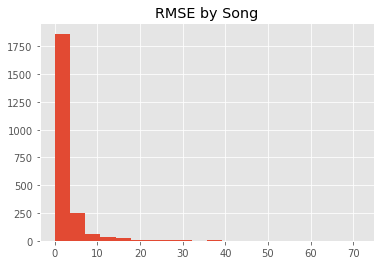

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

rmsevals = rmse_results['rmse_by_item']['rmse']

plt.hist(rmsevals, bins=20)
plt.title('RMSE by Song')
plt.show()

The RMSE of most songs is relatively low.   However, we can see a few songs with very high RMSE or errors in the prediction from the training set to the testing set.   

# To do:  find way to list highest RMSE songs

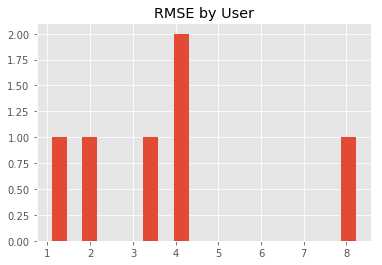

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

rmsevals = rmse_results['rmse_by_user']['rmse']
rmsevals = rmsevals[rmse_results['rmse_by_user']['count']>10]


plt.hist(rmsevals, bins=20)
plt.title('RMSE by User')
plt.show()

A few users have high RMSE.   As mentioned in the early analysis of the data, errors for the prediction of certain users may be related to multiple family members accessing the music using the same user ID.  In additon, the high RMSE may be due to eclectic music plays.

### Ranking Factorization Recommender
The ranking factorication recommender learns factors from the user and item.  This model of prediction is preferred for rankings.  Since the plays data is similar to ranking, we will explore the effectiveness of this model.   This model is also know as cross validating collaborative filtering.   The model is very time consuming to process with a large dataset. 

In [32]:
recl = gl.recommender.ranking_factorization_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays")

rmse_results = recl.evaluate(test_song)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 1489352 observations with 110000 users and 163095 items.

Data prepared in: 7.45266s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 186169 / 1489352 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 7.14286           | Not Viable                               |

| 1       | 1.78571           | Not Viable                               |

| 2       | 0.446429          | Not Viable                               |

| 3       | 0.111607          | 45.8463                                  |

| 4       | 0.0558036         | 52.5898                                  |

| 5       | 0.0279018         | 58.645                                   |

| 6       | 0.0139509         | 66.6812                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.111607          | 45.8463                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 96.5427           | 7.01751               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 10.19s       | 117.516           | 9.38127               | 0.111607    |

| 2       | 18.95s       | 90.0049           | 8.48664               | 0.111607    |

| 3       | 25.78s       | 81.1129           | 8.03501               | 0.111607    |

| 4       | 32.68s       | 75.3415           | 7.7355                | 0.111607    |

| 5       | 39.45s       | 70.7211           | 7.47561               | 0.111607    |

| 6       | 47.15s       | 66.9865           | 7.25383               | 0.111607    |

| 7       | 55.51s       | 63.3606           | 7.04504               | 0.111607    |

| 8       | 1m 2s        | 60.3683           | 6.86024               | 0.111607    |

| 9       | 1m 8s        | 57.6733           | 6.68613               | 0.111607    |

| 10      | 1m 14s       | 55.4521           | 6.54282               | 0.111607    |

| 11      | 1m 20s       | 53.3969           | 6.40814               | 0.111607    |

| 12      | 1m 26s       | 51.6787           | 6.29027               | 0.111607    |

| 13      | 1m 32s       | 50.2308           | 6.19508               | 0.111607    |

| 14      | 1m 39s       | 48.9113           | 6.09523               | 0.111607    |

| 15      | 1m 45s       | 48.1078           | 6.0406                | 0.111607    |

| 16      | 1m 51s       | 47.1232           | 5.97017               | 0.111607    |

| 17      | 1m 57s       | 46.3753           | 5.91299               | 0.111607    |

| 18      | 2m 4s        | 45.7849           | 5.86981               | 0.111607    |

| 19      | 2m 10s       | 45.1784           | 5.82483               | 0.111607    |

| 20      | 2m 15s       | 44.579            | 5.77614               | 0.111607    |

| 21      | 2m 21s       | 44.1783           | 5.74216               | 0.111607    |

| 22      | 2m 28s       | 43.7199           | 5.71141               | 0.111607    |

| 23      | 2m 33s       | 43.5897           | 5.7035                | 0.111607    |

| 24      | 2m 39s       | 43.3174           | 5.67375               | 0.111607    |

| 25      | 2m 45s       | 42.8912           | 5.63993               | 0.111607    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 40.7788

Final training RMSE: 5.4782


Precision and recall summary statistics by cutoff
+--------+-------------------+------------------+
| cutoff |   mean_precision  |   mean_recall    |
+--------+-------------------+------------------+
|   1    |  0.00115874855156 | 0.00115874855156 |
|   2    | 0.000579374275782 | 0.00115874855156 |
|   3    | 0.000386249517188 | 0.00115874855156 |
|   4    | 0.000289687137891 | 0.00115874855156 |
|   5    | 0.000231749710313 | 0.00115874855156 |
|   6    | 0.000193124758594 | 0.00115874855156 |
|   7    | 0.000165535507366 | 0.00115874855156 |
|   8    | 0.000289687137891 | 0.00173812282735 |
|   9    | 0.000257499678125 | 0.00173812282735 |
|   10   | 0.000347624565469 | 0.00289687137891 |
+--------+-------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 7.336147858253637)

Per User RMSE (best)
+-------------------------------+-------+------------------+
|              user             | count |       rmse       |
+-------------------------------+-------+-

In [33]:
rmse_results['rmse_overall']

7.336147858253637

The cross validation model increased the RMSE from 5.47 to 7.34.  

In [34]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall
36,0.000772499034376,0.00456744477277,0.0132097334878
2,0.000579374275782,0.0170103340161,0.00115874855156
46,0.000730515391204,0.00391753961527,0.0156237929703
31,0.000784958696221,0.00497042132122,0.0108922363847
26,0.000713076031732,0.00518821007607,0.0091348010815
8,0.000289687137891,0.0060105718196,0.00173812282735
5,0.000231749710313,0.00680413360644,0.00115874855156
16,0.000506952491309,0.005606026211,0.00453843182696
41,0.000763078314445,0.00424610146982,0.0140787949015
4,0.000289687137891,0.00850516700806,0.00115874855156


The aggregate of the precision and recall are evaluated for this model.   Precision is the measurement of not predicting falsely.  Recall is the measurement of correct predictions.  Accuracy is the measure the fraction of prediting correct.  

### Determine correct number of latent factors

Since the RMSE decreased with the cross validation, the model will be slightly adjusted from the default to analyze again with the number latent factors clearly designated.  Before determining the correct number of latent factors, models will be run for 4 different possible latent factors.  

In [ ]:
params = {'user_id': 'user',
         'item_id': 'song_id',
         'target': 'plays',
         'num_factors': [4, 10, 20],
         'regularization': [0.001] ,
         'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train_song,test_song),
                                      gl.recommender.ranking_factorization_recommender.create,
                                      params,
                                      max_models=3,
                                      environment=None)


In [ ]:
job.get_status()

In [ ]:
job_result = job.get_results()

job_result.head()

In [ ]:
bst_prms = job.get_best_params()
bst_prms

In [ ]:
models = job.get_models()
models

In [ ]:
comparisonstruct = gl.compare(test_song,models)
gl.show_comparison(comparisonstruct,models)

In [ ]:
models[1]

# Based on the results of the above - manually change the num_factors to that number for the latent factors.

In [35]:
recl = gl.recommender.ranking_factorization_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                              num_factors=10, 
                                                              regularization=1e-02,
                                                              linear_regularization = 1e-3)

rmse_results = recl.evaluate(test_song)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 1489352 observations with 110000 users and 163095 items.

Data prepared in: 8.24184s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 186169 / 1489352 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.00494718        | 101.421                                  |

| 1       | 0.00247359        | 102.21                                   |

| 2       | 0.00123679        | 102.788                                  |

| 3       | 0.000618397       | 103.115                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00494718        | 101.421                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 96.5428           | 7.01751               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 6.48s        | 95.9842           | 7.01284               | 0.00494718  |

| 2       | 12.42s       | 95.7085           | 7.00961               | 0.00494718  |

| 3       | 19.17s       | 94.885            | 7.00352               | 0.00494718  |

| 4       | 26.13s       | 94.3851           | 7.00151               | 0.00494718  |

| 5       | 38.39s       | 94.0415           | 7.00089               | 0.00494718  |

| 6       | 44.37s       | 93.7883           | 7.00106               | 0.00494718  |

| 7       | 50.31s       | 93.5931           | 7.00158               | 0.00494718  |

| 8       | 56.09s       | 93.437            | 7.00234               | 0.00494718  |

| 9       | 1m 1s        | 93.3091           | 7.00326               | 0.00494718  |

| 10      | 1m 7s        | 93.2024           | 7.00423               | 0.00494718  |

| 11      | 1m 12s       | 93.1112           | 7.0052                | 0.00494718  |

| 12      | 1m 18s       | 93.0326           | 7.00621               | 0.00494718  |

| 13      | 1m 25s       | 92.9635           | 7.00723               | 0.00494718  |

| 14      | 1m 32s       | 92.9026           | 7.00822               | 0.00494718  |

| 15      | 1m 39s       | 92.8482           | 7.00924               | 0.00494718  |

| 16      | 1m 45s       | 92.7991           | 7.01015               | 0.00494718  |

| 17      | 1m 52s       | 92.7546           | 7.01115               | 0.00494718  |

| 18      | 1m 58s       | 92.7139           | 7.01208               | 0.00494718  |

| 19      | 2m 5s        | 92.6769           | 7.013                 | 0.00494718  |

| 20      | 2m 10s       | 92.6417           | 7.0139                | 0.00494718  |

| 21      | 2m 16s       | 92.61             | 7.01475               | 0.00494718  |

| 22      | 2m 22s       | 92.5799           | 7.01558               | 0.00494718  |

| 23      | 2m 27s       | 92.5521           | 7.01643               | 0.00494718  |

| 24      | 2m 34s       | 92.526            | 7.01724               | 0.00494718  |

| 25      | 2m 41s       | 92.5012           | 7.01803               | 0.00494718  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 92.5765

Final training RMSE: 7.01629


Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.00811123986095 | 0.00341830822711 |
|   2    | 0.00521436848204 | 0.00438393202008 |
|   3    | 0.00733874082657 | 0.00795674005407 |
|   4    | 0.00753186558517 |  0.010982361272  |
|   5    | 0.00741599073001 | 0.0133430815354  |
|   6    | 0.00753186558517 | 0.0159309533006  |
|   7    | 0.00711802681675 | 0.0179008258383  |
|   8    | 0.00666280417149 | 0.0193492615277  |
|   9    | 0.00630874211407 | 0.0222461329066  |
|   10   | 0.00648899188876 | 0.0250745327802  |
+--------+------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 5.432064322885311)

Per User RMSE (best)
+-------------------------------+-------+-----------------+
|              user             | count |       rmse      |
+-------------------------------+-------+-----------------

In [36]:
rmse_results['rmse_overall']

5.432064322885311

In [37]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall
36,0.00366937041329,0.0113049947058,0.0533682295559
2,0.00521436848204,0.0507936472637,0.00438393202008
46,0.00335029472518,0.00988688322599,0.0619972276983
31,0.00407430942324,0.0128635856388,0.0504230769874
26,0.00432302344237,0.0147019251721,0.0446569234808
8,0.00666280417149,0.033381965073,0.0193492615277
5,0.00741599073001,0.041307394978,0.0133430815354
16,0.00579374275782,0.0215483714723,0.0373154237291
41,0.0034197213351,0.0102372237457,0.0562375116836
4,0.00753186558517,0.0443968576145,0.010982361272


The comparison between the models

In [ ]:
comparisonstruct = gl.compare(test_song, [song_rec, recl])

In [31]:
comparisonstruct = gl.compare(test_song, [song_rec, recl])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
36,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [ ]:
gl.show_comparison(comparisonstruct,[song_rec, recl])

## Summarize the Ramifications

## Deployment

## Exceptional Work

## References

Reference for the dataset:
@INPROCEEDINGS{Bertin-Mahieux2011,
  author = {Thierry Bertin-Mahieux and Daniel P.W. Ellis and Brian Whitman and Paul Lamere},
  title = {The Million Song Dataset},
  booktitle = {{Proceedings of the 12th International Conference on Music Information
	Retrieval ({ISMIR} 2011)}},
  year = {2011},
  owner = {thierry},
  timestamp = {2010.03.07}
  